In [202]:
import numpy as np
from numpy.fft import rfft, irfft, rfftfreq
import matplotlib.pyplot as plt
import imageio
from scipy.ndimage import gaussian_filter1d as gfilt
N = 2048
Nfft = N//2+1

In [157]:
def shift(data, Nx):
    if Nx==0:
        return np.copy(data)
    return np.hstack((data[Nx:],data[:Nx]))
    
def cross_xi(data1, data2):
    return irfft(rfft(data1)*np.conj(rfft(data2)))


def observe_noisy(data):
    return data+np.random.normal(0,1,len(data))


In [195]:
shift_true = 800
#template = np.random.normal(0,1e-3,N)
template = irfft(np.exp(1j*np.random.uniform(0,2*np.pi,Nfft)))
template /= np.sqrt(np.var(template))
template *= 1e-3
beam = np.linspace(1.3,0.8,Nfft)+1j*np.sin(np.linspace(0,2*np.pi,Nfft))
template_obs = irfft(rfft(template)*beam)
template_obs_shifted = shift(template_obs,shift_true)


In [227]:
def acquire_signal(Nac = 62500, plot_every=1000):
    names = []
    cross = np.zeros(len(template))
    for cc in range(Nac):
        cross += cross_xi(observe_noisy(template_obs_shifted),template)
        
        if cc%plot_every == 1:
            plt.figure()
            crossplot = cross/cc
            plt.plot(crossplot)
            plt.figtext(0.2,0.8,f"Time = {1e-8*cc*N:2.7f}s")
            ac = np.argmax(crossplot)
            nsigma = crossplot[ac]/np.sqrt(np.var(crossplot))
            if nsigma>5:
                plt.figtext (0.2,0.75,f"Acquired: {N-ac} (true={shift_true}, {nsigma:2.2f} sigma")
                plt.plot(ac,crossplot[ac],'ro')
            pc = cc//plot_every
            name = f"ac{pc}.png"
            plt.ylim(-0.001,+0.003)
            plt.xlabel('delay bin')
            plt.savefig(name,dpi=150)
            names.append(name)
            plt.close()                         
    return names

names = acquire_signal()
with imageio.get_writer('acquire.gif', mode='I') as writer:
    for filename in names:
        image = imageio.imread(filename)
        writer.append_data(image)


In [228]:
def measure_signal(Nac = 6250000, plot_every=100000):
    names = []
    ftemp = rfft(template)
    fact = np.conj(ftemp)/np.abs(ftemp**2)
    sol = np.zeros(len(ftemp), np.complex)
    gbeamr = gfilt(np.real(beam),20)
    gbeami = gfilt(np.imag(beam),20)
    for cc in range(Nac):
        sol += rfft(observe_noisy(template_obs))*fact
        
        if cc%plot_every == 1:
            plt.figure()
            facplot = sol/cc
            facplotr = gfilt(np.real(facplot),20)
            facploti = gfilt(np.imag(facplot),20)
            plt.subplot(2,1,1)
            plt.plot(facplotr,'b-')
            plt.plot(gbeamr,'r--')
            plt.ylim(0,3)
            plt.ylabel('real response')
            plt.subplot(2,1,2)
            plt.plot(facploti,'b-')
            plt.plot(gbeami,'r--')
            plt.xlabel('delay freq')
            plt.ylabel('imag response')
            plt.ylim(-3,3)
            snr = 1/np.sqrt(np.var((facplotr-gbeamr)/gbeamr))
            plt.figtext(0.2,0.8,f"Time = {1e-8*cc*N:2.1f}s  SNR per 0.5 MHZ= {snr:2.2f}")
            pc = cc//plot_every
            name = f"me{pc}.png"
            #plt.ylim(-0.001,+0.0025)
            plt.savefig(name,dpi=150)
            names.append(name)
            plt.close()                         
            #stop()
    return names

names = measure_signal()
with imageio.get_writer('measure.gif', mode='I') as writer:
    for filename in names:
        image = imageio.imread(filename)
        writer.append_data(image)


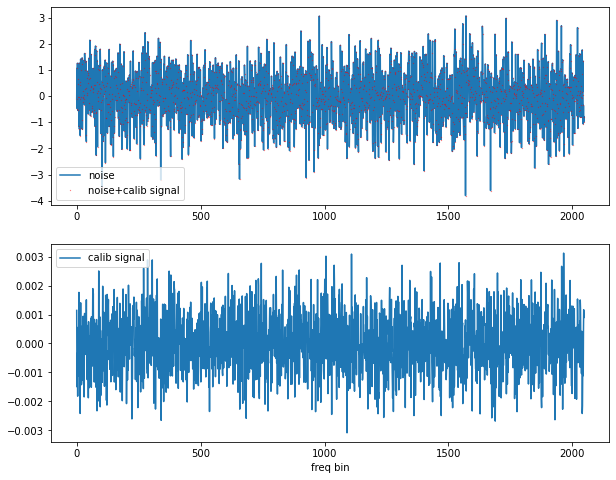

In [229]:
noise = observe_noisy(template*0)
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.plot(noise,label='noise')
plt.plot(noise+template,'r.',markersize=0.4,label='noise+calib signal')
plt.legend()
plt.subplot(2,1,2)
plt.plot(template, label='calib signal')
plt.xlabel('freq bin')
plt.legend()